# Assignment 1 | Image Classification, November 12, 2021

- [Artificial Neural Networks and Deep Learning 2021 - Homework 1](https://codalab.lisn.upsaclay.fr/competitions/226)

## Three convolutioneers

- *Aleksandra Krajnovic*
- *Iva Milojkovic*
- *Mariusz Wiśniewski*

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import shutil
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tfk.layers
print(tf.__version__)

2.6.0


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
HISTORIES = []

In [4]:
def plot_training(histories):
    plt.figure(figsize=(15, 5))
    for idx, history in enumerate(histories):
        plt.plot(history[0]['loss'], label=history[1] + ' training', alpha=.3, color=COLORS[idx], linestyle='--')
        plt.plot(history[0]['val_loss'], label=history[1] + ' validation', alpha=.8, color=COLORS[idx])

    plt.legend(loc='upper right')
    plt.title('Categorical Cross-entropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(15, 5))
    for idx, history in enumerate(histories):
        plt.plot(history[0]['categorical_accuracy'], label=history[1] + ' training', alpha=.3, color=COLORS[idx],
                 linestyle='--')
        plt.plot(history[0]['val_categorical_accuracy'], label=history[1] + ' validation', alpha=.8, color=COLORS[idx])

    plt.legend(loc='upper right')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

In [5]:
dataset_dir = '/kaggle/input/leafdataset'
training_dir = os.path.join(dataset_dir, 'training')

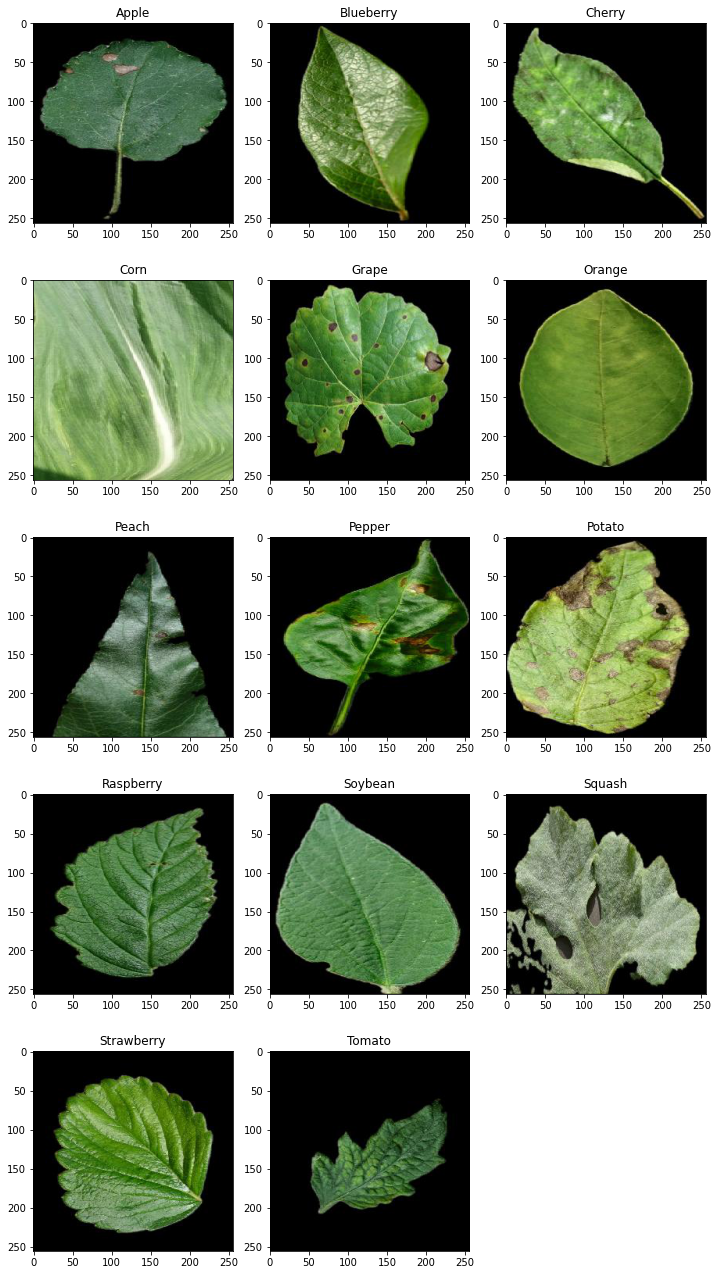

In [6]:
labels = {0: 'Apple',
          1: 'Blueberry',
          2: 'Cherry',
          3: 'Corn',
          4: 'Grape',
          5: 'Orange',
          6: 'Peach',
          7: 'Pepper',
          8: 'Potato',
          9: 'Raspberry',
          10: 'Soybean',
          11: 'Squash',
          12: 'Strawberry',
          13: 'Tomato'}
# Plot example images from dataset

N_CLASSES = len(labels)

n_rows = 5
n_cols = 3
counts = []

fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_rows, 6 * n_cols))
for i in range(n_rows * n_cols):
    if i < len(labels):
        class_imgs = next(
            os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
        counts.append(len(class_imgs))
        class_img = class_imgs[0]
        img = Image.open(
            '{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i // n_cols, i % n_cols]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
axes[-1, -1].set_visible(False)
plt.tight_layout()
plt.show()

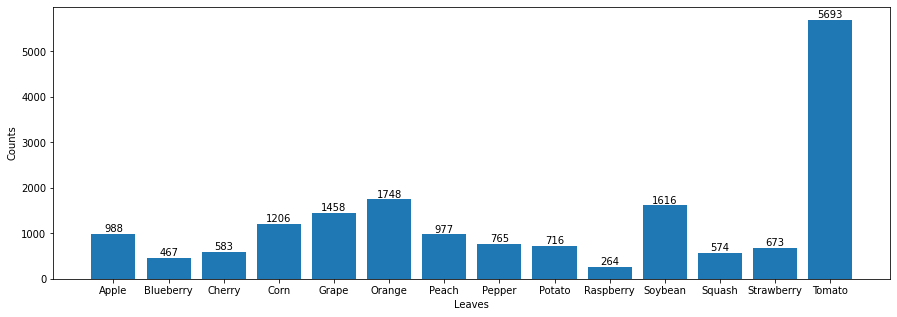

In [7]:
plt.figure(figsize=(15, 5))
plt.bar(labels.values(), counts, align='center')
for i in range(len(counts)):
    plt.annotate(str(counts[i]), xy=(labels[i], counts[i]), ha='center', va='bottom')
plt.xlabel('Leaves')
plt.ylabel('Counts')
plt.show()

### Models metadata

In [8]:
input_shape = (256, 256, 3)
epochs = 200

In [9]:
# Utility function to create folders and callbacks for training
from datetime import datetime


def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, 'cp'),
        save_weights_only=False,
        save_best_only=False)
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)
    callbacks.append(tb_callback)

    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)
    callbacks.append(es_callback)

    reduce = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=5)
    callbacks.append(reduce)

    return callbacks

## Resnet50

### Basic augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess_input

rn_no_aug_train_data_gen = ImageDataGenerator(validation_split=0.2,
                                              preprocessing_function=resnet_v2_preprocess_input)

# Create an instance of ImageDataGenerator with Data Augmentation
rn_aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                           height_shift_range=50,
                                           width_shift_range=50,
                                           zoom_range=0.3,
                                           brightness_range=[0.2, 1.0],
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           fill_mode='reflect',
                                           validation_split=0.2,
                                           preprocessing_function=resnet_v2_preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
rn_aug_train_gen = rn_aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                             target_size=(
                                                                 256, 256),
                                                             color_mode='rgb',
                                                             classes=None,
                                                             batch_size=8,
                                                             shuffle=True,
                                                             seed=seed,
                                                             subset='training')

rn_valid_gen = rn_no_aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                            target_size=(
                                                                256, 256),
                                                            color_mode='rgb',
                                                            classes=None,
                                                            batch_size=8,
                                                            shuffle=False,
                                                            seed=seed,
                                                            subset='validation')

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


In [11]:
resnet_model = tfk.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

2021-11-27 19:19:29.419991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 19:19:29.518902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 19:19:29.519599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 19:19:29.521350: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 0s 0us/step


#### Transfer learning

In [12]:
from tensorflow.keras import backend as K

def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
            m
    FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
        c=1
    where m = number of classes, c = class and o = observation
    Parameters:
    alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
    categories/labels, the size of the array needs to be consistent with the number of classes.
    gamma -- focusing parameter for modulating factor (1-p)
    Default value:
    gamma -- 2.0 as mentioned in the paper
    alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
    model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed

In [13]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(rn_aug_train_gen.classes),
                                                  rn_aug_train_gen.classes)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13], y=[ 0  0  0 ... 13 13 13] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [14]:
resnet_model.trainable = False

inputs = tfk.Input(shape=input_shape)
out = resnet_model(inputs)
out = tfkl.GlobalAveragePooling2D()(out)
out = tfkl.Dense(
    256,
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed),
    name='fc_start')(out)
out = tfkl.Dropout(0.5, seed=seed)(out)
out = tfkl.Dense(
    128,
    activation='relu',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)
out = tfkl.BatchNormalization()(out)
out = tfkl.Dropout(0.5, seed=seed)(out)
outputs = tfkl.Dense(
    N_CLASSES,
    activation='softmax',
    kernel_initializer=tfk.initializers.GlorotUniform(seed))(out)

# # Connect input and output through the Model class
rn_aug_tl_model = tfk.Model(
    inputs=inputs, outputs=outputs, name='rn_aug_tl_model')

rn_aug_tl_model.compile(loss=[categorical_focal_loss(alpha=[class_weights])],
                        optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
                        metrics=[
                            tfk.metrics.CategoricalAccuracy(),
                            [tfk.metrics.Precision(class_id=idx, name='Precision_' + labels[idx]) for idx in
                             range(N_CLASSES)],
                            [tfk.metrics.Recall(class_id=idx, name='Recall_' + labels[idx]) for idx in
                             range(N_CLASSES)],
])

In [15]:
rn_aug_tl_callbacks_r = create_folders_and_callbacks(model_name='CNN_Aug_RN_TL_FL')

rn_aug_tl_history_r = rn_aug_tl_model.fit(
    x=rn_aug_train_gen,
    epochs=epochs,
    validation_data=rn_valid_gen,
    callbacks=rn_aug_tl_callbacks_r
).history

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2021-11-27 19:19:35.248326: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2021-11-27 19:19:43.512616: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1774/1774 [==============================] - 338s 183ms/step - loss: 2.1787 - categorical_accuracy: 0.2498 - Precision_Apple: 0.1327 - Precision_Blueberry: 0.1373 - Precision_Cherry: 0.1059 - Precision_Corn: 0.6927 - Precision_Grape: 0.4746 - Precision_Orange: 0.5580 - Precision_Peach: 0.3149 - Precision_Pepper: 0.1568 - Precision_Potato: 0.2120 - Precision_Raspberry: 0.1429 - Precision_Soybean: 0.4300 - Precision_Squash: 0.2570 - Precision_Strawberry: 0.2470 - Precision_Tomato: 0.7545 - Recall_Apple: 0.0354 - Recall_Blueberry: 0.1123 - Recall_Cherry: 0.0578 - Recall_Corn: 0.4228 - Recall_Grape: 0.1602 - Recall_Orange: 0.2337 - Recall_Peach: 0.1458 - Recall_Pepper: 0.0735 - Recall_Potato: 0.0803 - Recall_Raspberry: 0.2264 - Recall_Soybean: 0.0688 - Recall_Squash: 0.2000 - Recall_Strawberry: 0.1521 - Recall_Tomato: 0.0735 - val_loss: 0.5972 - val_categorical_accuracy: 0.7016 - val_Precision_Apple: 0.0000e+00 - val_Precision_Blueberry: 0.7903 - val_Precision_Cherry: 0.0000e+00 - val_Prec

2021-11-27 19:25:23.211883: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
1774/1774 [==============================] - 291s 164ms/step - loss: 1.1810 - categorical_accuracy: 0.4669 - Precision_Apple: 0.3431 - Precision_Blueberry: 0.3548 - Precision_Cherry: 0.3125 - Precision_Corn: 0.8657 - Precision_Grape: 0.6690 - Precision_Orange: 0.8152 - Precision_Peach: 0.6065 - Precision_Pepper: 0.4104 - Precision_Potato: 0.4608 - Precision_Raspberry: 0.3274 - Precision_Soybean: 0.7412 - Precision_Squash: 0.5828 - Precision_Strawberry: 0.4709 - Precision_Tomato: 0.9228 - Recall_Apple: 0.0885 - Recall_Blueberry: 0.3235 - Recall_Cherry: 0.1820 - Recall_Corn: 0.7347 - Recall_Grape: 0.4053 - Recall_Orange: 0.5139 - Recall_Peach: 0.3824 - Recall_Pepper: 0.2582 - Recall_Potato: 0.2565 - Recall_Raspberry: 0.5189 - Recall_Soybean: 0.2436 - Recall_Squash: 0.5587 - Recall_Strawberry: 0.4508 - Recall_Tomato: 0.1917 - val_loss: 0.3666 - val_categorical_accuracy: 0.7604 - val_Precision_Apple: 0.7048 - val_Precision_Blueberry: 0.8384 - val_Precision_Cherry: 0.8125 - val_

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/200
1774/1774 [==============================] - 294s 166ms/step - loss: 0.8429 - categorical_accuracy: 0.5749 - Precision_Apple: 0.4424 - Precision_Blueberry: 0.4307 - Precision_Cherry: 0.4818 - Precision_Corn: 0.9224 - Precision_Grape: 0.7256 - Precision_Orange: 0.8799 - Precision_Peach: 0.7243 - Precision_Pepper: 0.5034 - Precision_Potato: 0.6060 - Precision_Raspberry: 0.4314 - Precision_Soybean: 0.8153 - Precision_Squash: 0.7039 - Precision_Strawberry: 0.5455 - Precision_Tomato: 0.9482 - Recall_Apple: 0.1795 - Recall_Blueberry: 0.3824 - Recall_Cherry: 0.3683 - Recall_Corn: 0.8124 - Recall_Grape: 0.5099 - Recall_Orange: 0.6076 - Recall_Peach: 0.5409 - Recall_Pepper: 0.3578 - Recall_Potato: 0.4590 - Recall_Raspberry: 0.6226 - Recall_Soybean: 0.3790 - Recall_Squash: 0.6978 - Recall_Strawberry: 0.5343 - Recall_Tomato: 0.3052 - val_loss: 0.2717 - val_categorical_accuracy: 0.8296 - val_Precision_Apple: 0.9032 - val_Precision_Blueberry: 0.7333 - val_Precision_Cherry: 0.8605 - val_

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/200
1774/1774 [==============================] - 298s 168ms/step - loss: 0.6796 - categorical_accuracy: 0.6437 - Precision_Apple: 0.5662 - Precision_Blueberry: 0.5417 - Precision_Cherry: 0.5260 - Precision_Corn: 0.9471 - Precision_Grape: 0.7767 - Precision_Orange: 0.9143 - Precision_Peach: 0.7625 - Precision_Pepper: 0.5570 - Precision_Potato: 0.6407 - Precision_Raspberry: 0.5551 - Precision_Soybean: 0.8442 - Precision_Squash: 0.7330 - Precision_Strawberry: 0.6004 - Precision_Tomato: 0.9534 - Recall_Apple: 0.2541 - Recall_Blueberry: 0.5214 - Recall_Cherry: 0.4111 - Recall_Corn: 0.8539 - Recall_Grape: 0.5544 - Recall_Orange: 0.6941 - Recall_Peach: 0.6036 - Recall_Pepper: 0.4314 - Recall_Potato: 0.5602 - Recall_Raspberry: 0.6651 - Recall_Soybean: 0.4818 - Recall_Squash: 0.7283 - Recall_Strawberry: 0.5826 - Recall_Tomato: 0.3866 - val_loss: 0.2122 - val_categorical_accuracy: 0.8508 - val_Precision_Apple: 0.7329 - val_Precision_Blueberry: 0.7583 - val_Precision_Cherry: 0.9348 - val_

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/200
1774/1774 [==============================] - 301s 169ms/step - loss: 0.5791 - categorical_accuracy: 0.6866 - Precision_Apple: 0.6090 - Precision_Blueberry: 0.6005 - Precision_Cherry: 0.5753 - Precision_Corn: 0.9661 - Precision_Grape: 0.8304 - Precision_Orange: 0.9327 - Precision_Peach: 0.8154 - Precision_Pepper: 0.5881 - Precision_Potato: 0.5930 - Precision_Raspberry: 0.5774 - Precision_Soybean: 0.8798 - Precision_Squash: 0.7862 - Precision_Strawberry: 0.6922 - Precision_Tomato: 0.9585 - Recall_Apple: 0.3072 - Recall_Blueberry: 0.5909 - Recall_Cherry: 0.4989 - Recall_Corn: 0.8860 - Recall_Grape: 0.6375 - Recall_Orange: 0.7334 - Recall_Peach: 0.6893 - Recall_Pepper: 0.5016 - Recall_Potato: 0.5620 - Recall_Raspberry: 0.7217 - Recall_Soybean: 0.5661 - Recall_Squash: 0.7674 - Recall_Strawberry: 0.6549 - Recall_Tomato: 0.4408 - val_loss: 0.1771 - val_categorical_accuracy: 0.8590 - val_Precision_Apple: 0.7207 - val_Precision_Blueberry: 0.7647 - val_Precision_Cherry: 0.8810 - val_

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/200
1774/1774 [==============================] - 308s 174ms/step - loss: 0.4808 - categorical_accuracy: 0.7308 - Precision_Apple: 0.6667 - Precision_Blueberry: 0.6974 - Precision_Cherry: 0.6053 - Precision_Corn: 0.9694 - Precision_Grape: 0.8612 - Precision_Orange: 0.9466 - Precision_Peach: 0.8435 - Precision_Pepper: 0.6419 - Precision_Potato: 0.6655 - Precision_Raspberry: 0.6535 - Precision_Soybean: 0.9052 - Precision_Squash: 0.7991 - Precision_Strawberry: 0.7046 - Precision_Tomato: 0.9712 - Recall_Apple: 0.3742 - Recall_Blueberry: 0.6471 - Recall_Cherry: 0.4925 - Recall_Corn: 0.8860 - Recall_Grape: 0.7069 - Recall_Orange: 0.7727 - Recall_Peach: 0.7097 - Recall_Pepper: 0.6062 - Recall_Potato: 0.6457 - Recall_Raspberry: 0.7830 - Recall_Soybean: 0.6427 - Recall_Squash: 0.8043 - Recall_Strawberry: 0.7124 - Recall_Tomato: 0.4968 - val_loss: 0.1557 - val_categorical_accuracy: 0.8816 - val_Precision_Apple: 0.8082 - val_Precision_Blueberry: 0.6970 - val_Precision_Cherry: 0.9744 - val_

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/200
1774/1774 [==============================] - 322s 182ms/step - loss: 0.4294 - categorical_accuracy: 0.7524 - Precision_Apple: 0.6787 - Precision_Blueberry: 0.7017 - Precision_Cherry: 0.6628 - Precision_Corn: 0.9669 - Precision_Grape: 0.8864 - Precision_Orange: 0.9418 - Precision_Peach: 0.8416 - Precision_Pepper: 0.6684 - Precision_Potato: 0.6684 - Precision_Raspberry: 0.6953 - Precision_Soybean: 0.9073 - Precision_Squash: 0.8344 - Precision_Strawberry: 0.7357 - Precision_Tomato: 0.9580 - Recall_Apple: 0.4273 - Recall_Blueberry: 0.6791 - Recall_Cherry: 0.6060 - Recall_Corn: 0.9078 - Recall_Grape: 0.7421 - Recall_Orange: 0.7984 - Recall_Peach: 0.7340 - Recall_Pepper: 0.6422 - Recall_Potato: 0.6545 - Recall_Raspberry: 0.8396 - Recall_Soybean: 0.6435 - Recall_Squash: 0.8326 - Recall_Strawberry: 0.7180 - Recall_Tomato: 0.5207 - val_loss: 0.1497 - val_categorical_accuracy: 0.8836 - val_Precision_Apple: 0.7680 - val_Precision_Blueberry: 0.7302 - val_Precision_Cherry: 0.9452 - val_

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/200
1774/1774 [==============================] - 325s 183ms/step - loss: 0.4001 - categorical_accuracy: 0.7667 - Precision_Apple: 0.7469 - Precision_Blueberry: 0.7363 - Precision_Cherry: 0.6497 - Precision_Corn: 0.9722 - Precision_Grape: 0.8723 - Precision_Orange: 0.9598 - Precision_Peach: 0.8420 - Precision_Pepper: 0.6898 - Precision_Potato: 0.6805 - Precision_Raspberry: 0.6836 - Precision_Soybean: 0.9247 - Precision_Squash: 0.8753 - Precision_Strawberry: 0.7322 - Precision_Tomato: 0.9649 - Recall_Apple: 0.4627 - Recall_Blueberry: 0.7540 - Recall_Cherry: 0.5996 - Recall_Corn: 0.9067 - Recall_Grape: 0.7609 - Recall_Orange: 0.8184 - Recall_Peach: 0.7634 - Recall_Pepper: 0.6503 - Recall_Potato: 0.7173 - Recall_Raspberry: 0.8255 - Recall_Soybean: 0.6930 - Recall_Squash: 0.8391 - Recall_Strawberry: 0.7458 - Recall_Tomato: 0.5304 - val_loss: 0.1598 - val_categorical_accuracy: 0.8833 - val_Precision_Apple: 0.7463 - val_Precision_Blueberry: 0.7132 - val_Precision_Cherry: 0.9667 - val_

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/200
1774/1774 [==============================] - 311s 176ms/step - loss: 0.3614 - categorical_accuracy: 0.7803 - Precision_Apple: 0.7629 - Precision_Blueberry: 0.7731 - Precision_Cherry: 0.6981 - Precision_Corn: 0.9757 - Precision_Grape: 0.9050 - Precision_Orange: 0.9584 - Precision_Peach: 0.8772 - Precision_Pepper: 0.7238 - Precision_Potato: 0.6607 - Precision_Raspberry: 0.7066 - Precision_Soybean: 0.9160 - Precision_Squash: 0.8519 - Precision_Strawberry: 0.7691 - Precision_Tomato: 0.9680 - Recall_Apple: 0.5044 - Recall_Blueberry: 0.7834 - Recall_Cherry: 0.6338 - Recall_Corn: 0.9140 - Recall_Grape: 0.7841 - Recall_Orange: 0.8399 - Recall_Peach: 0.7673 - Recall_Pepper: 0.6765 - Recall_Potato: 0.7068 - Recall_Raspberry: 0.8632 - Recall_Soybean: 0.7254 - Recall_Squash: 0.8500 - Recall_Strawberry: 0.7848 - Recall_Tomato: 0.5374 - val_loss: 0.1254 - val_categorical_accuracy: 0.8949 - val_Precision_Apple: 0.8511 - val_Precision_Blueberry: 0.8070 - val_Precision_Cherry: 0.9518 - val_

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/200
1774/1774 [==============================] - 314s 177ms/step - loss: 0.3310 - categorical_accuracy: 0.7986 - Precision_Apple: 0.7773 - Precision_Blueberry: 0.7880 - Precision_Cherry: 0.7405 - Precision_Corn: 0.9802 - Precision_Grape: 0.9125 - Precision_Orange: 0.9657 - Precision_Peach: 0.8470 - Precision_Pepper: 0.7253 - Precision_Potato: 0.7124 - Precision_Raspberry: 0.7121 - Precision_Soybean: 0.9325 - Precision_Squash: 0.8531 - Precision_Strawberry: 0.7359 - Precision_Tomato: 0.9730 - Recall_Apple: 0.5032 - Recall_Blueberry: 0.7754 - Recall_Cherry: 0.6660 - Recall_Corn: 0.9212 - Recall_Grape: 0.8218 - Recall_Orange: 0.8242 - Recall_Peach: 0.7928 - Recall_Pepper: 0.6944 - Recall_Potato: 0.7609 - Recall_Raspberry: 0.8868 - Recall_Soybean: 0.7154 - Recall_Squash: 0.8587 - Recall_Strawberry: 0.7755 - Recall_Tomato: 0.5697 - val_loss: 0.1287 - val_categorical_accuracy: 0.8988 - val_Precision_Apple: 0.8701 - val_Precision_Blueberry: 0.7360 - val_Precision_Cherry: 0.9867 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/200
1774/1774 [==============================] - 312s 176ms/step - loss: 0.2908 - categorical_accuracy: 0.8173 - Precision_Apple: 0.8127 - Precision_Blueberry: 0.8370 - Precision_Cherry: 0.7906 - Precision_Corn: 0.9837 - Precision_Grape: 0.9066 - Precision_Orange: 0.9683 - Precision_Peach: 0.8816 - Precision_Pepper: 0.7439 - Precision_Potato: 0.7165 - Precision_Raspberry: 0.7692 - Precision_Soybean: 0.9430 - Precision_Squash: 0.8855 - Precision_Strawberry: 0.7959 - Precision_Tomato: 0.9727 - Recall_Apple: 0.5487 - Recall_Blueberry: 0.8235 - Recall_Cherry: 0.6874 - Recall_Corn: 0.9389 - Recall_Grape: 0.8063 - Recall_Orange: 0.8528 - Recall_Peach: 0.8095 - Recall_Pepper: 0.7026 - Recall_Potato: 0.7365 - Recall_Raspberry: 0.8491 - Recall_Soybean: 0.7804 - Recall_Squash: 0.8913 - Recall_Strawberry: 0.7885 - Recall_Tomato: 0.6110 - val_loss: 0.1171 - val_categorical_accuracy: 0.9005 - val_Precision_Apple: 0.8122 - val_Precision_Blueberry: 0.8000 - val_Precision_Cherry: 0.9767 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/200
1774/1774 [==============================] - 318s 179ms/step - loss: 0.2803 - categorical_accuracy: 0.8268 - Precision_Apple: 0.8236 - Precision_Blueberry: 0.8199 - Precision_Cherry: 0.7730 - Precision_Corn: 0.9749 - Precision_Grape: 0.9205 - Precision_Orange: 0.9672 - Precision_Peach: 0.8828 - Precision_Pepper: 0.7545 - Precision_Potato: 0.7200 - Precision_Raspberry: 0.7479 - Precision_Soybean: 0.9436 - Precision_Squash: 0.9170 - Precision_Strawberry: 0.7653 - Precision_Tomato: 0.9742 - Recall_Apple: 0.5904 - Recall_Blueberry: 0.7914 - Recall_Cherry: 0.7002 - Recall_Corn: 0.9254 - Recall_Grape: 0.8338 - Recall_Orange: 0.8427 - Recall_Peach: 0.8095 - Recall_Pepper: 0.7484 - Recall_Potato: 0.7853 - Recall_Raspberry: 0.8538 - Recall_Soybean: 0.7889 - Recall_Squash: 0.9130 - Recall_Strawberry: 0.8108 - Recall_Tomato: 0.6294 - val_loss: 0.1170 - val_categorical_accuracy: 0.9053 - val_Precision_Apple: 0.8629 - val_Precision_Blueberry: 0.6866 - val_Precision_Cherry: 0.9659 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/200
1774/1774 [==============================] - 315s 178ms/step - loss: 0.2666 - categorical_accuracy: 0.8299 - Precision_Apple: 0.8034 - Precision_Blueberry: 0.8225 - Precision_Cherry: 0.7765 - Precision_Corn: 0.9806 - Precision_Grape: 0.9287 - Precision_Orange: 0.9646 - Precision_Peach: 0.9021 - Precision_Pepper: 0.7758 - Precision_Potato: 0.7277 - Precision_Raspberry: 0.7613 - Precision_Soybean: 0.9443 - Precision_Squash: 0.8908 - Precision_Strawberry: 0.8333 - Precision_Tomato: 0.9746 - Recall_Apple: 0.5891 - Recall_Blueberry: 0.8422 - Recall_Cherry: 0.7216 - Recall_Corn: 0.9409 - Recall_Grape: 0.8149 - Recall_Orange: 0.8578 - Recall_Peach: 0.8133 - Recall_Pepper: 0.7239 - Recall_Potato: 0.7836 - Recall_Raspberry: 0.8726 - Recall_Soybean: 0.7873 - Recall_Squash: 0.8870 - Recall_Strawberry: 0.8349 - Recall_Tomato: 0.6318 - val_loss: 0.1111 - val_categorical_accuracy: 0.8983 - val_Precision_Apple: 0.8606 - val_Precision_Blueberry: 0.7797 - val_Precision_Cherry: 0.9592 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/200
1774/1774 [==============================] - 313s 177ms/step - loss: 0.2516 - categorical_accuracy: 0.8385 - Precision_Apple: 0.7922 - Precision_Blueberry: 0.8464 - Precision_Cherry: 0.8023 - Precision_Corn: 0.9824 - Precision_Grape: 0.9307 - Precision_Orange: 0.9661 - Precision_Peach: 0.8988 - Precision_Pepper: 0.7822 - Precision_Potato: 0.7403 - Precision_Raspberry: 0.7899 - Precision_Soybean: 0.9512 - Precision_Squash: 0.9011 - Precision_Strawberry: 0.7990 - Precision_Tomato: 0.9789 - Recall_Apple: 0.5929 - Recall_Blueberry: 0.8396 - Recall_Cherry: 0.7473 - Recall_Corn: 0.9275 - Recall_Grape: 0.8518 - Recall_Orange: 0.8563 - Recall_Peach: 0.8286 - Recall_Pepper: 0.7631 - Recall_Potato: 0.8010 - Recall_Raspberry: 0.8868 - Recall_Soybean: 0.7997 - Recall_Squash: 0.9109 - Recall_Strawberry: 0.8479 - Recall_Tomato: 0.6422 - val_loss: 0.0951 - val_categorical_accuracy: 0.9260 - val_Precision_Apple: 0.9043 - val_Precision_Blueberry: 0.7360 - val_Precision_Cherry: 0.9612 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/200
1774/1774 [==============================] - 317s 179ms/step - loss: 0.2473 - categorical_accuracy: 0.8472 - Precision_Apple: 0.8064 - Precision_Blueberry: 0.8503 - Precision_Cherry: 0.8051 - Precision_Corn: 0.9891 - Precision_Grape: 0.9360 - Precision_Orange: 0.9690 - Precision_Peach: 0.8983 - Precision_Pepper: 0.8071 - Precision_Potato: 0.7386 - Precision_Raspberry: 0.8370 - Precision_Soybean: 0.9503 - Precision_Squash: 0.8939 - Precision_Strawberry: 0.8382 - Precision_Tomato: 0.9681 - Recall_Apple: 0.6056 - Recall_Blueberry: 0.8503 - Recall_Cherry: 0.7430 - Recall_Corn: 0.9389 - Recall_Grape: 0.8526 - Recall_Orange: 0.8728 - Recall_Peach: 0.8248 - Recall_Pepper: 0.7794 - Recall_Potato: 0.7941 - Recall_Raspberry: 0.8962 - Recall_Soybean: 0.8128 - Recall_Squash: 0.8978 - Recall_Strawberry: 0.8460 - Recall_Tomato: 0.6527 - val_loss: 0.0998 - val_categorical_accuracy: 0.9161 - val_Precision_Apple: 0.8978 - val_Precision_Blueberry: 0.7419 - val_Precision_Cherry: 0.9881 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/200
1774/1774 [==============================] - 312s 176ms/step - loss: 0.2297 - categorical_accuracy: 0.8503 - Precision_Apple: 0.8230 - Precision_Blueberry: 0.8579 - Precision_Cherry: 0.8226 - Precision_Corn: 0.9870 - Precision_Grape: 0.9404 - Precision_Orange: 0.9738 - Precision_Peach: 0.9153 - Precision_Pepper: 0.7702 - Precision_Potato: 0.7327 - Precision_Raspberry: 0.8274 - Precision_Soybean: 0.9558 - Precision_Squash: 0.9239 - Precision_Strawberry: 0.8330 - Precision_Tomato: 0.9757 - Recall_Apple: 0.6346 - Recall_Blueberry: 0.8556 - Recall_Cherry: 0.7645 - Recall_Corn: 0.9440 - Recall_Grape: 0.8518 - Recall_Orange: 0.8763 - Recall_Peach: 0.8427 - Recall_Pepper: 0.7778 - Recall_Potato: 0.7941 - Recall_Raspberry: 0.8821 - Recall_Soybean: 0.8198 - Recall_Squash: 0.8978 - Recall_Strawberry: 0.8516 - Recall_Tomato: 0.6437 - val_loss: 0.0967 - val_categorical_accuracy: 0.9294 - val_Precision_Apple: 0.9671 - val_Precision_Blueberry: 0.6345 - val_Precision_Cherry: 0.9806 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/200
1774/1774 [==============================] - 308s 173ms/step - loss: 0.2156 - categorical_accuracy: 0.8624 - Precision_Apple: 0.8347 - Precision_Blueberry: 0.8680 - Precision_Cherry: 0.8612 - Precision_Corn: 0.9827 - Precision_Grape: 0.9493 - Precision_Orange: 0.9810 - Precision_Peach: 0.9110 - Precision_Pepper: 0.8038 - Precision_Potato: 0.7378 - Precision_Raspberry: 0.8067 - Precision_Soybean: 0.9596 - Precision_Squash: 0.9379 - Precision_Strawberry: 0.7967 - Precision_Tomato: 0.9756 - Recall_Apple: 0.6384 - Recall_Blueberry: 0.8262 - Recall_Cherry: 0.7837 - Recall_Corn: 0.9409 - Recall_Grape: 0.8672 - Recall_Orange: 0.8849 - Recall_Peach: 0.8248 - Recall_Pepper: 0.7631 - Recall_Potato: 0.8150 - Recall_Raspberry: 0.9057 - Recall_Soybean: 0.8275 - Recall_Squash: 0.9196 - Recall_Strawberry: 0.8071 - Recall_Tomato: 0.6663 - val_loss: 0.1093 - val_categorical_accuracy: 0.9147 - val_Precision_Apple: 0.9144 - val_Precision_Blueberry: 0.7863 - val_Precision_Cherry: 1.0000 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/200
1774/1774 [==============================] - 317s 179ms/step - loss: 0.2124 - categorical_accuracy: 0.8669 - Precision_Apple: 0.8310 - Precision_Blueberry: 0.9074 - Precision_Cherry: 0.8231 - Precision_Corn: 0.9859 - Precision_Grape: 0.9464 - Precision_Orange: 0.9713 - Precision_Peach: 0.9110 - Precision_Pepper: 0.8319 - Precision_Potato: 0.7911 - Precision_Raspberry: 0.8376 - Precision_Soybean: 0.9530 - Precision_Squash: 0.8950 - Precision_Strawberry: 0.8545 - Precision_Tomato: 0.9805 - Recall_Apple: 0.6776 - Recall_Blueberry: 0.8904 - Recall_Cherry: 0.7773 - Recall_Corn: 0.9430 - Recall_Grape: 0.8783 - Recall_Orange: 0.8964 - Recall_Peach: 0.8504 - Recall_Pepper: 0.7843 - Recall_Potato: 0.8394 - Recall_Raspberry: 0.9245 - Recall_Soybean: 0.8461 - Recall_Squash: 0.9261 - Recall_Strawberry: 0.8609 - Recall_Tomato: 0.6738 - val_loss: 0.0911 - val_categorical_accuracy: 0.9172 - val_Precision_Apple: 0.9341 - val_Precision_Blueberry: 0.8142 - val_Precision_Cherry: 0.9901 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/200
1774/1774 [==============================] - 304s 172ms/step - loss: 0.1977 - categorical_accuracy: 0.8760 - Precision_Apple: 0.8614 - Precision_Blueberry: 0.8695 - Precision_Cherry: 0.8501 - Precision_Corn: 0.9820 - Precision_Grape: 0.9498 - Precision_Orange: 0.9798 - Precision_Peach: 0.9269 - Precision_Pepper: 0.8224 - Precision_Potato: 0.7744 - Precision_Raspberry: 0.8721 - Precision_Soybean: 0.9597 - Precision_Squash: 0.9203 - Precision_Strawberry: 0.8404 - Precision_Tomato: 0.9785 - Recall_Apple: 0.6991 - Recall_Blueberry: 0.8904 - Recall_Cherry: 0.7773 - Recall_Corn: 0.9617 - Recall_Grape: 0.8757 - Recall_Orange: 0.9021 - Recall_Peach: 0.8427 - Recall_Pepper: 0.8023 - Recall_Potato: 0.8325 - Recall_Raspberry: 0.9009 - Recall_Soybean: 0.8469 - Recall_Squash: 0.9283 - Recall_Strawberry: 0.8404 - Recall_Tomato: 0.6909 - val_loss: 0.0948 - val_categorical_accuracy: 0.9212 - val_Precision_Apple: 0.9100 - val_Precision_Blueberry: 0.8846 - val_Precision_Cherry: 0.9798 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/200
1774/1774 [==============================] - 309s 174ms/step - loss: 0.2059 - categorical_accuracy: 0.8750 - Precision_Apple: 0.8671 - Precision_Blueberry: 0.8820 - Precision_Cherry: 0.8545 - Precision_Corn: 0.9840 - Precision_Grape: 0.9517 - Precision_Orange: 0.9807 - Precision_Peach: 0.9357 - Precision_Pepper: 0.8439 - Precision_Potato: 0.7397 - Precision_Raspberry: 0.8435 - Precision_Soybean: 0.9576 - Precision_Squash: 0.9314 - Precision_Strawberry: 0.8663 - Precision_Tomato: 0.9796 - Recall_Apple: 0.6928 - Recall_Blueberry: 0.8797 - Recall_Cherry: 0.7923 - Recall_Corn: 0.9544 - Recall_Grape: 0.8955 - Recall_Orange: 0.9056 - Recall_Peach: 0.8555 - Recall_Pepper: 0.7859 - Recall_Potato: 0.8133 - Recall_Raspberry: 0.9151 - Recall_Soybean: 0.8391 - Recall_Squash: 0.9152 - Recall_Strawberry: 0.8534 - Recall_Tomato: 0.6858 - val_loss: 0.0883 - val_categorical_accuracy: 0.9246 - val_Precision_Apple: 0.9259 - val_Precision_Blueberry: 0.8142 - val_Precision_Cherry: 1.0000 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/200
1774/1774 [==============================] - 300s 169ms/step - loss: 0.1881 - categorical_accuracy: 0.8722 - Precision_Apple: 0.8574 - Precision_Blueberry: 0.8889 - Precision_Cherry: 0.8855 - Precision_Corn: 0.9850 - Precision_Grape: 0.9471 - Precision_Orange: 0.9813 - Precision_Peach: 0.9197 - Precision_Pepper: 0.8455 - Precision_Potato: 0.7532 - Precision_Raspberry: 0.8603 - Precision_Soybean: 0.9571 - Precision_Squash: 0.9229 - Precision_Strawberry: 0.8627 - Precision_Tomato: 0.9801 - Recall_Apple: 0.6764 - Recall_Blueberry: 0.8984 - Recall_Cherry: 0.8116 - Recall_Corn: 0.9513 - Recall_Grape: 0.8740 - Recall_Orange: 0.9014 - Recall_Peach: 0.8645 - Recall_Pepper: 0.8137 - Recall_Potato: 0.8255 - Recall_Raspberry: 0.9292 - Recall_Soybean: 0.8291 - Recall_Squash: 0.9109 - Recall_Strawberry: 0.8627 - Recall_Tomato: 0.6806 - val_loss: 0.0601 - val_categorical_accuracy: 0.9528 - val_Precision_Apple: 0.9333 - val_Precision_Blueberry: 0.8519 - val_Precision_Cherry: 0.9900 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/200
1774/1774 [==============================] - 300s 169ms/step - loss: 0.1832 - categorical_accuracy: 0.8810 - Precision_Apple: 0.8775 - Precision_Blueberry: 0.8954 - Precision_Cherry: 0.8739 - Precision_Corn: 0.9892 - Precision_Grape: 0.9576 - Precision_Orange: 0.9774 - Precision_Peach: 0.9129 - Precision_Pepper: 0.8164 - Precision_Potato: 0.7488 - Precision_Raspberry: 0.8472 - Precision_Soybean: 0.9644 - Precision_Squash: 0.9322 - Precision_Strawberry: 0.8537 - Precision_Tomato: 0.9799 - Recall_Apple: 0.7244 - Recall_Blueberry: 0.8930 - Recall_Cherry: 0.8308 - Recall_Corn: 0.9523 - Recall_Grape: 0.8895 - Recall_Orange: 0.8985 - Recall_Peach: 0.8708 - Recall_Pepper: 0.8137 - Recall_Potato: 0.8272 - Recall_Raspberry: 0.9151 - Recall_Soybean: 0.8600 - Recall_Squash: 0.9261 - Recall_Strawberry: 0.8664 - Recall_Tomato: 0.6966 - val_loss: 0.0690 - val_categorical_accuracy: 0.9438 - val_Precision_Apple: 0.9301 - val_Precision_Blueberry: 0.7931 - val_Precision_Cherry: 0.9899 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/200
1774/1774 [==============================] - 301s 170ms/step - loss: 0.1811 - categorical_accuracy: 0.8829 - Precision_Apple: 0.8589 - Precision_Blueberry: 0.8836 - Precision_Cherry: 0.8741 - Precision_Corn: 0.9894 - Precision_Grape: 0.9539 - Precision_Orange: 0.9745 - Precision_Peach: 0.9108 - Precision_Pepper: 0.8417 - Precision_Potato: 0.7887 - Precision_Raspberry: 0.8858 - Precision_Soybean: 0.9602 - Precision_Squash: 0.9363 - Precision_Strawberry: 0.8722 - Precision_Tomato: 0.9819 - Recall_Apple: 0.7155 - Recall_Blueberry: 0.8930 - Recall_Cherry: 0.8180 - Recall_Corn: 0.9668 - Recall_Grape: 0.8869 - Recall_Orange: 0.9014 - Recall_Peach: 0.8619 - Recall_Pepper: 0.8252 - Recall_Potato: 0.8272 - Recall_Raspberry: 0.9151 - Recall_Soybean: 0.8585 - Recall_Squash: 0.9261 - Recall_Strawberry: 0.8738 - Recall_Tomato: 0.7008 - val_loss: 0.0708 - val_categorical_accuracy: 0.9429 - val_Precision_Apple: 0.9563 - val_Precision_Blueberry: 0.8846 - val_Precision_Cherry: 0.9796 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/200
1774/1774 [==============================] - 306s 172ms/step - loss: 0.1655 - categorical_accuracy: 0.8902 - Precision_Apple: 0.8772 - Precision_Blueberry: 0.9084 - Precision_Cherry: 0.8962 - Precision_Corn: 0.9819 - Precision_Grape: 0.9555 - Precision_Orange: 0.9817 - Precision_Peach: 0.9373 - Precision_Pepper: 0.8643 - Precision_Potato: 0.7941 - Precision_Raspberry: 0.8362 - Precision_Soybean: 0.9661 - Precision_Squash: 0.9409 - Precision_Strawberry: 0.8757 - Precision_Tomato: 0.9828 - Recall_Apple: 0.7042 - Recall_Blueberry: 0.9011 - Recall_Cherry: 0.8137 - Recall_Corn: 0.9544 - Recall_Grape: 0.9023 - Recall_Orange: 0.9221 - Recall_Peach: 0.8798 - Recall_Pepper: 0.8431 - Recall_Potato: 0.8412 - Recall_Raspberry: 0.9151 - Recall_Soybean: 0.8592 - Recall_Squash: 0.9348 - Recall_Strawberry: 0.8887 - Recall_Tomato: 0.7131 - val_loss: 0.0629 - val_categorical_accuracy: 0.9477 - val_Precision_Apple: 0.9200 - val_Precision_Blueberry: 0.8846 - val_Precision_Cherry: 0.9898 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/200
1774/1774 [==============================] - 308s 173ms/step - loss: 0.1776 - categorical_accuracy: 0.8846 - Precision_Apple: 0.8558 - Precision_Blueberry: 0.9192 - Precision_Cherry: 0.8628 - Precision_Corn: 0.9946 - Precision_Grape: 0.9566 - Precision_Orange: 0.9798 - Precision_Peach: 0.9208 - Precision_Pepper: 0.8692 - Precision_Potato: 0.7934 - Precision_Raspberry: 0.8304 - Precision_Soybean: 0.9562 - Precision_Squash: 0.9108 - Precision_Strawberry: 0.8731 - Precision_Tomato: 0.9811 - Recall_Apple: 0.6827 - Recall_Blueberry: 0.8824 - Recall_Cherry: 0.8351 - Recall_Corn: 0.9534 - Recall_Grape: 0.8877 - Recall_Orange: 0.9021 - Recall_Peach: 0.8772 - Recall_Pepper: 0.8252 - Recall_Potato: 0.8447 - Recall_Raspberry: 0.9009 - Recall_Soybean: 0.8616 - Recall_Squash: 0.9326 - Recall_Strawberry: 0.8553 - Recall_Tomato: 0.7063 - val_loss: 0.0610 - val_categorical_accuracy: 0.9457 - val_Precision_Apple: 0.9333 - val_Precision_Blueberry: 0.8440 - val_Precision_Cherry: 0.9899 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 26/200
1774/1774 [==============================] - 308s 174ms/step - loss: 0.1663 - categorical_accuracy: 0.8901 - Precision_Apple: 0.8758 - Precision_Blueberry: 0.9218 - Precision_Cherry: 0.8912 - Precision_Corn: 0.9946 - Precision_Grape: 0.9589 - Precision_Orange: 0.9830 - Precision_Peach: 0.9215 - Precision_Pepper: 0.8436 - Precision_Potato: 0.7788 - Precision_Raspberry: 0.8824 - Precision_Soybean: 0.9715 - Precision_Squash: 0.9364 - Precision_Strawberry: 0.8716 - Precision_Tomato: 0.9832 - Recall_Apple: 0.7219 - Recall_Blueberry: 0.9144 - Recall_Cherry: 0.8244 - Recall_Corn: 0.9585 - Recall_Grape: 0.8989 - Recall_Orange: 0.9092 - Recall_Peach: 0.8708 - Recall_Pepper: 0.8284 - Recall_Potato: 0.8482 - Recall_Raspberry: 0.9198 - Recall_Soybean: 0.8701 - Recall_Squash: 0.9283 - Recall_Strawberry: 0.8942 - Recall_Tomato: 0.7203 - val_loss: 0.0672 - val_categorical_accuracy: 0.9407 - val_Precision_Apple: 0.9216 - val_Precision_Blueberry: 0.9109 - val_Precision_Cherry: 0.9808 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/200
1774/1774 [==============================] - 310s 175ms/step - loss: 0.1581 - categorical_accuracy: 0.8949 - Precision_Apple: 0.8653 - Precision_Blueberry: 0.9246 - Precision_Cherry: 0.8935 - Precision_Corn: 0.9925 - Precision_Grape: 0.9754 - Precision_Orange: 0.9824 - Precision_Peach: 0.9412 - Precision_Pepper: 0.8501 - Precision_Potato: 0.7728 - Precision_Raspberry: 0.9128 - Precision_Soybean: 0.9651 - Precision_Squash: 0.9404 - Precision_Strawberry: 0.8905 - Precision_Tomato: 0.9819 - Recall_Apple: 0.7636 - Recall_Blueberry: 0.8850 - Recall_Cherry: 0.8266 - Recall_Corn: 0.9575 - Recall_Grape: 0.8826 - Recall_Orange: 0.9157 - Recall_Peach: 0.9003 - Recall_Pepper: 0.8431 - Recall_Potato: 0.8429 - Recall_Raspberry: 0.9387 - Recall_Soybean: 0.8770 - Recall_Squash: 0.9261 - Recall_Strawberry: 0.8905 - Recall_Tomato: 0.7139 - val_loss: 0.0654 - val_categorical_accuracy: 0.9421 - val_Precision_Apple: 0.9337 - val_Precision_Blueberry: 0.8598 - val_Precision_Cherry: 0.9810 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/200
1774/1774 [==============================] - 312s 176ms/step - loss: 0.1504 - categorical_accuracy: 0.9010 - Precision_Apple: 0.8873 - Precision_Blueberry: 0.9288 - Precision_Cherry: 0.8804 - Precision_Corn: 0.9936 - Precision_Grape: 0.9616 - Precision_Orange: 0.9848 - Precision_Peach: 0.9491 - Precision_Pepper: 0.8622 - Precision_Potato: 0.7870 - Precision_Raspberry: 0.9083 - Precision_Soybean: 0.9626 - Precision_Squash: 0.9540 - Precision_Strawberry: 0.9146 - Precision_Tomato: 0.9828 - Recall_Apple: 0.7661 - Recall_Blueberry: 0.9064 - Recall_Cherry: 0.8351 - Recall_Corn: 0.9606 - Recall_Grape: 0.9006 - Recall_Orange: 0.9292 - Recall_Peach: 0.8824 - Recall_Pepper: 0.8284 - Recall_Potato: 0.8639 - Recall_Raspberry: 0.9340 - Recall_Soybean: 0.8755 - Recall_Squash: 0.9478 - Recall_Strawberry: 0.8738 - Recall_Tomato: 0.7282 - val_loss: 0.0664 - val_categorical_accuracy: 0.9404 - val_Precision_Apple: 0.9337 - val_Precision_Blueberry: 0.8440 - val_Precision_Cherry: 0.9808 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/200
1774/1774 [==============================] - 319s 180ms/step - loss: 0.1446 - categorical_accuracy: 0.9011 - Precision_Apple: 0.8860 - Precision_Blueberry: 0.9326 - Precision_Cherry: 0.8927 - Precision_Corn: 0.9914 - Precision_Grape: 0.9668 - Precision_Orange: 0.9842 - Precision_Peach: 0.9363 - Precision_Pepper: 0.8919 - Precision_Potato: 0.7677 - Precision_Raspberry: 0.9124 - Precision_Soybean: 0.9761 - Precision_Squash: 0.9316 - Precision_Strawberry: 0.8773 - Precision_Tomato: 0.9819 - Recall_Apple: 0.7762 - Recall_Blueberry: 0.9251 - Recall_Cherry: 0.8373 - Recall_Corn: 0.9596 - Recall_Grape: 0.8980 - Recall_Orange: 0.9350 - Recall_Peach: 0.9028 - Recall_Pepper: 0.8497 - Recall_Potato: 0.8534 - Recall_Raspberry: 0.9340 - Recall_Soybean: 0.8840 - Recall_Squash: 0.9174 - Recall_Strawberry: 0.9017 - Recall_Tomato: 0.7269 - val_loss: 0.0627 - val_categorical_accuracy: 0.9441 - val_Precision_Apple: 0.9293 - val_Precision_Blueberry: 0.8519 - val_Precision_Cherry: 0.9800 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 30/200
1774/1774 [==============================] - 302s 170ms/step - loss: 0.1372 - categorical_accuracy: 0.9082 - Precision_Apple: 0.8948 - Precision_Blueberry: 0.9428 - Precision_Cherry: 0.9218 - Precision_Corn: 0.9872 - Precision_Grape: 0.9728 - Precision_Orange: 0.9872 - Precision_Peach: 0.9388 - Precision_Pepper: 0.8805 - Precision_Potato: 0.8076 - Precision_Raspberry: 0.9078 - Precision_Soybean: 0.9689 - Precision_Squash: 0.9522 - Precision_Strawberry: 0.9039 - Precision_Tomato: 0.9845 - Recall_Apple: 0.7851 - Recall_Blueberry: 0.9251 - Recall_Cherry: 0.8587 - Recall_Corn: 0.9575 - Recall_Grape: 0.9177 - Recall_Orange: 0.9335 - Recall_Peach: 0.9028 - Recall_Pepper: 0.8546 - Recall_Potato: 0.8499 - Recall_Raspberry: 0.9292 - Recall_Soybean: 0.8917 - Recall_Squash: 0.9522 - Recall_Strawberry: 0.9072 - Recall_Tomato: 0.7398 - val_loss: 0.0616 - val_categorical_accuracy: 0.9457 - val_Precision_Apple: 0.9340 - val_Precision_Blueberry: 0.8440 - val_Precision_Cherry: 0.9802 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/200
1774/1774 [==============================] - 300s 169ms/step - loss: 0.1465 - categorical_accuracy: 0.9028 - Precision_Apple: 0.8859 - Precision_Blueberry: 0.9272 - Precision_Cherry: 0.8968 - Precision_Corn: 0.9915 - Precision_Grape: 0.9590 - Precision_Orange: 0.9770 - Precision_Peach: 0.9361 - Precision_Pepper: 0.8750 - Precision_Potato: 0.7900 - Precision_Raspberry: 0.8929 - Precision_Soybean: 0.9795 - Precision_Squash: 0.9409 - Precision_Strawberry: 0.9032 - Precision_Tomato: 0.9832 - Recall_Apple: 0.7851 - Recall_Blueberry: 0.9198 - Recall_Cherry: 0.8373 - Recall_Corn: 0.9627 - Recall_Grape: 0.9023 - Recall_Orange: 0.9114 - Recall_Peach: 0.8990 - Recall_Pepper: 0.8693 - Recall_Potato: 0.8534 - Recall_Raspberry: 0.9434 - Recall_Soybean: 0.8863 - Recall_Squash: 0.9348 - Recall_Strawberry: 0.8998 - Recall_Tomato: 0.7317 - val_loss: 0.0579 - val_categorical_accuracy: 0.9483 - val_Precision_Apple: 0.9337 - val_Precision_Blueberry: 0.8440 - val_Precision_Cherry: 0.9808 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 32/200
1774/1774 [==============================] - 309s 174ms/step - loss: 0.1422 - categorical_accuracy: 0.9044 - Precision_Apple: 0.8755 - Precision_Blueberry: 0.9380 - Precision_Cherry: 0.8904 - Precision_Corn: 0.9873 - Precision_Grape: 0.9589 - Precision_Orange: 0.9848 - Precision_Peach: 0.9424 - Precision_Pepper: 0.8861 - Precision_Potato: 0.7941 - Precision_Raspberry: 0.8578 - Precision_Soybean: 0.9656 - Precision_Squash: 0.9558 - Precision_Strawberry: 0.9203 - Precision_Tomato: 0.9810 - Recall_Apple: 0.7737 - Recall_Blueberry: 0.9305 - Recall_Cherry: 0.8522 - Recall_Corn: 0.9668 - Recall_Grape: 0.9186 - Recall_Orange: 0.9278 - Recall_Peach: 0.8990 - Recall_Pepper: 0.8644 - Recall_Potato: 0.8883 - Recall_Raspberry: 0.9387 - Recall_Soybean: 0.8910 - Recall_Squash: 0.9413 - Recall_Strawberry: 0.8998 - Recall_Tomato: 0.7363 - val_loss: 0.0631 - val_categorical_accuracy: 0.9446 - val_Precision_Apple: 0.9104 - val_Precision_Blueberry: 0.8440 - val_Precision_Cherry: 0.9804 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/200
1774/1774 [==============================] - 324s 183ms/step - loss: 0.1332 - categorical_accuracy: 0.9093 - Precision_Apple: 0.8892 - Precision_Blueberry: 0.9362 - Precision_Cherry: 0.9112 - Precision_Corn: 0.9978 - Precision_Grape: 0.9667 - Precision_Orange: 0.9864 - Precision_Peach: 0.9364 - Precision_Pepper: 0.8706 - Precision_Potato: 0.8107 - Precision_Raspberry: 0.9434 - Precision_Soybean: 0.9704 - Precision_Squash: 0.9355 - Precision_Strawberry: 0.9112 - Precision_Tomato: 0.9841 - Recall_Apple: 0.7914 - Recall_Blueberry: 0.9412 - Recall_Cherry: 0.8565 - Recall_Corn: 0.9617 - Recall_Grape: 0.9212 - Recall_Orange: 0.9335 - Recall_Peach: 0.9041 - Recall_Pepper: 0.8464 - Recall_Potato: 0.8743 - Recall_Raspberry: 0.9434 - Recall_Soybean: 0.8886 - Recall_Squash: 0.9457 - Recall_Strawberry: 0.8942 - Recall_Tomato: 0.7456 - val_loss: 0.0610 - val_categorical_accuracy: 0.9460 - val_Precision_Apple: 0.9064 - val_Precision_Blueberry: 0.8932 - val_Precision_Cherry: 0.9897 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/200
1774/1774 [==============================] - 306s 173ms/step - loss: 0.1365 - categorical_accuracy: 0.9079 - Precision_Apple: 0.8861 - Precision_Blueberry: 0.9333 - Precision_Cherry: 0.9105 - Precision_Corn: 0.9936 - Precision_Grape: 0.9689 - Precision_Orange: 0.9848 - Precision_Peach: 0.9537 - Precision_Pepper: 0.8981 - Precision_Potato: 0.8333 - Precision_Raspberry: 0.8950 - Precision_Soybean: 0.9695 - Precision_Squash: 0.9227 - Precision_Strawberry: 0.8743 - Precision_Tomato: 0.9832 - Recall_Apple: 0.7573 - Recall_Blueberry: 0.9358 - Recall_Cherry: 0.8715 - Recall_Corn: 0.9720 - Recall_Grape: 0.9066 - Recall_Orange: 0.9264 - Recall_Peach: 0.8964 - Recall_Pepper: 0.8644 - Recall_Potato: 0.8726 - Recall_Raspberry: 0.9245 - Recall_Soybean: 0.8855 - Recall_Squash: 0.9348 - Recall_Strawberry: 0.8776 - Recall_Tomato: 0.7467 - val_loss: 0.0615 - val_categorical_accuracy: 0.9452 - val_Precision_Apple: 0.9163 - val_Precision_Blueberry: 0.8932 - val_Precision_Cherry: 0.9903 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 35/200
1774/1774 [==============================] - 308s 173ms/step - loss: 0.1315 - categorical_accuracy: 0.9147 - Precision_Apple: 0.9196 - Precision_Blueberry: 0.9402 - Precision_Cherry: 0.9212 - Precision_Corn: 0.9947 - Precision_Grape: 0.9673 - Precision_Orange: 0.9850 - Precision_Peach: 0.9491 - Precision_Pepper: 0.8778 - Precision_Potato: 0.7942 - Precision_Raspberry: 0.9058 - Precision_Soybean: 0.9716 - Precision_Squash: 0.9541 - Precision_Strawberry: 0.9030 - Precision_Tomato: 0.9872 - Recall_Apple: 0.7952 - Recall_Blueberry: 0.9251 - Recall_Cherry: 0.8758 - Recall_Corn: 0.9648 - Recall_Grape: 0.9126 - Recall_Orange: 0.9400 - Recall_Peach: 0.9066 - Recall_Pepper: 0.8333 - Recall_Potato: 0.8551 - Recall_Raspberry: 0.9528 - Recall_Soybean: 0.9010 - Recall_Squash: 0.9500 - Recall_Strawberry: 0.8813 - Recall_Tomato: 0.7594 - val_loss: 0.0599 - val_categorical_accuracy: 0.9457 - val_Precision_Apple: 0.9200 - val_Precision_Blueberry: 0.8846 - val_Precision_Cherry: 0.9905 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/200
1774/1774 [==============================] - 317s 179ms/step - loss: 0.1366 - categorical_accuracy: 0.9062 - Precision_Apple: 0.8809 - Precision_Blueberry: 0.9431 - Precision_Cherry: 0.9089 - Precision_Corn: 0.9915 - Precision_Grape: 0.9742 - Precision_Orange: 0.9863 - Precision_Peach: 0.9423 - Precision_Pepper: 0.8571 - Precision_Potato: 0.7872 - Precision_Raspberry: 0.9058 - Precision_Soybean: 0.9721 - Precision_Squash: 0.9264 - Precision_Strawberry: 0.9157 - Precision_Tomato: 0.9876 - Recall_Apple: 0.7851 - Recall_Blueberry: 0.9305 - Recall_Cherry: 0.8544 - Recall_Corn: 0.9617 - Recall_Grape: 0.9075 - Recall_Orange: 0.9278 - Recall_Peach: 0.8977 - Recall_Pepper: 0.8627 - Recall_Potato: 0.8778 - Recall_Raspberry: 0.9528 - Recall_Soybean: 0.8902 - Recall_Squash: 0.9304 - Recall_Strawberry: 0.9072 - Recall_Tomato: 0.7352 - val_loss: 0.0608 - val_categorical_accuracy: 0.9441 - val_Precision_Apple: 0.9163 - val_Precision_Blueberry: 0.8598 - val_Precision_Cherry: 0.9904 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 37/200
1774/1774 [==============================] - 317s 179ms/step - loss: 0.1321 - categorical_accuracy: 0.9118 - Precision_Apple: 0.8997 - Precision_Blueberry: 0.9497 - Precision_Cherry: 0.9147 - Precision_Corn: 0.9979 - Precision_Grape: 0.9673 - Precision_Orange: 0.9871 - Precision_Peach: 0.9341 - Precision_Pepper: 0.8879 - Precision_Potato: 0.8029 - Precision_Raspberry: 0.9346 - Precision_Soybean: 0.9641 - Precision_Squash: 0.9404 - Precision_Strawberry: 0.9130 - Precision_Tomato: 0.9831 - Recall_Apple: 0.7826 - Recall_Blueberry: 0.9091 - Recall_Cherry: 0.8501 - Recall_Corn: 0.9731 - Recall_Grape: 0.9135 - Recall_Orange: 0.9328 - Recall_Peach: 0.8875 - Recall_Pepper: 0.8546 - Recall_Potato: 0.8604 - Recall_Raspberry: 0.9434 - Recall_Soybean: 0.8933 - Recall_Squash: 0.9609 - Recall_Strawberry: 0.9147 - Recall_Tomato: 0.7548 - val_loss: 0.0607 - val_categorical_accuracy: 0.9426 - val_Precision_Apple: 0.9158 - val_Precision_Blueberry: 0.8598 - val_Precision_Cherry: 0.9905 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/200
1774/1774 [==============================] - 304s 171ms/step - loss: 0.1284 - categorical_accuracy: 0.9116 - Precision_Apple: 0.9050 - Precision_Blueberry: 0.9280 - Precision_Cherry: 0.9163 - Precision_Corn: 0.9884 - Precision_Grape: 0.9778 - Precision_Orange: 0.9878 - Precision_Peach: 0.9540 - Precision_Pepper: 0.8759 - Precision_Potato: 0.8285 - Precision_Raspberry: 0.9306 - Precision_Soybean: 0.9806 - Precision_Squash: 0.9436 - Precision_Strawberry: 0.9170 - Precision_Tomato: 0.9826 - Recall_Apple: 0.7712 - Recall_Blueberry: 0.9305 - Recall_Cherry: 0.8672 - Recall_Corn: 0.9731 - Recall_Grape: 0.9040 - Recall_Orange: 0.9242 - Recall_Peach: 0.9015 - Recall_Pepper: 0.8301 - Recall_Potato: 0.8935 - Recall_Raspberry: 0.9481 - Recall_Soybean: 0.8979 - Recall_Squash: 0.9457 - Recall_Strawberry: 0.9221 - Recall_Tomato: 0.7572 - val_loss: 0.0603 - val_categorical_accuracy: 0.9463 - val_Precision_Apple: 0.9200 - val_Precision_Blueberry: 0.8519 - val_Precision_Cherry: 0.9904 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 39/200
1774/1774 [==============================] - 308s 174ms/step - loss: 0.1375 - categorical_accuracy: 0.9102 - Precision_Apple: 0.8917 - Precision_Blueberry: 0.9553 - Precision_Cherry: 0.9019 - Precision_Corn: 0.9895 - Precision_Grape: 0.9693 - Precision_Orange: 0.9802 - Precision_Peach: 0.9396 - Precision_Pepper: 0.8761 - Precision_Potato: 0.8226 - Precision_Raspberry: 0.9140 - Precision_Soybean: 0.9722 - Precision_Squash: 0.9581 - Precision_Strawberry: 0.9056 - Precision_Tomato: 0.9857 - Recall_Apple: 0.7914 - Recall_Blueberry: 0.9144 - Recall_Cherry: 0.8266 - Recall_Corn: 0.9720 - Recall_Grape: 0.9186 - Recall_Orange: 0.9221 - Recall_Peach: 0.8951 - Recall_Pepper: 0.8317 - Recall_Potato: 0.8656 - Recall_Raspberry: 0.9528 - Recall_Soybean: 0.8910 - Recall_Squash: 0.9457 - Recall_Strawberry: 0.9258 - Recall_Tomato: 0.7561 - val_loss: 0.0609 - val_categorical_accuracy: 0.9446 - val_Precision_Apple: 0.9154 - val_Precision_Blueberry: 0.8598 - val_Precision_Cherry: 0.9905 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 40/200
1774/1774 [==============================] - 317s 179ms/step - loss: 0.1380 - categorical_accuracy: 0.9095 - Precision_Apple: 0.9054 - Precision_Blueberry: 0.9303 - Precision_Cherry: 0.9074 - Precision_Corn: 0.9904 - Precision_Grape: 0.9625 - Precision_Orange: 0.9863 - Precision_Peach: 0.9427 - Precision_Pepper: 0.8760 - Precision_Potato: 0.8228 - Precision_Raspberry: 0.9065 - Precision_Soybean: 0.9772 - Precision_Squash: 0.9360 - Precision_Strawberry: 0.9099 - Precision_Tomato: 0.9789 - Recall_Apple: 0.7990 - Recall_Blueberry: 0.9278 - Recall_Cherry: 0.8608 - Recall_Corn: 0.9668 - Recall_Grape: 0.9246 - Recall_Orange: 0.9264 - Recall_Peach: 0.9054 - Recall_Pepper: 0.8546 - Recall_Potato: 0.8429 - Recall_Raspberry: 0.9151 - Recall_Soybean: 0.8956 - Recall_Squash: 0.9543 - Recall_Strawberry: 0.8998 - Recall_Tomato: 0.7423 - val_loss: 0.0591 - val_categorical_accuracy: 0.9463 - val_Precision_Apple: 0.9293 - val_Precision_Blueberry: 0.8519 - val_Precision_Cherry: 0.9811 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 41/200
1774/1774 [==============================] - 327s 184ms/step - loss: 0.1367 - categorical_accuracy: 0.9096 - Precision_Apple: 0.8910 - Precision_Blueberry: 0.9444 - Precision_Cherry: 0.9057 - Precision_Corn: 0.9832 - Precision_Grape: 0.9626 - Precision_Orange: 0.9864 - Precision_Peach: 0.9506 - Precision_Pepper: 0.8809 - Precision_Potato: 0.8040 - Precision_Raspberry: 0.8938 - Precision_Soybean: 0.9730 - Precision_Squash: 0.9435 - Precision_Strawberry: 0.8959 - Precision_Tomato: 0.9855 - Recall_Apple: 0.7851 - Recall_Blueberry: 0.9091 - Recall_Cherry: 0.8437 - Recall_Corn: 0.9679 - Recall_Grape: 0.9263 - Recall_Orange: 0.9299 - Recall_Peach: 0.9105 - Recall_Pepper: 0.8578 - Recall_Potato: 0.8517 - Recall_Raspberry: 0.9528 - Recall_Soybean: 0.8917 - Recall_Squash: 0.9435 - Recall_Strawberry: 0.8942 - Recall_Tomato: 0.7464 - val_loss: 0.0599 - val_categorical_accuracy: 0.9466 - val_Precision_Apple: 0.9246 - val_Precision_Blueberry: 0.8440 - val_Precision_Cherry: 0.9811 - val

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


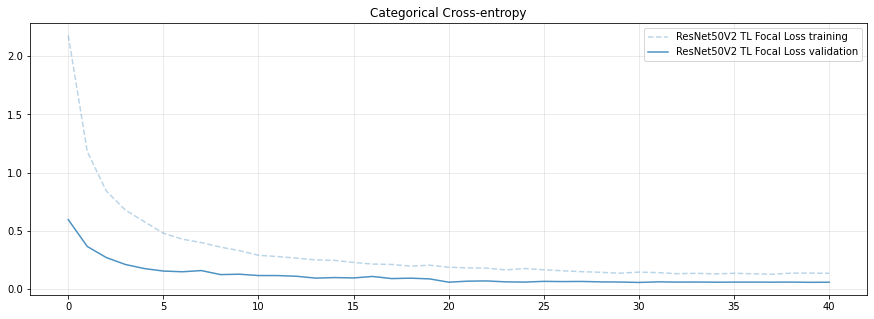

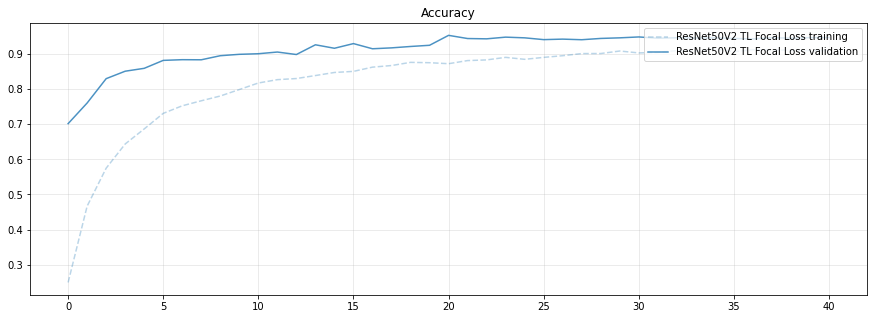

In [16]:
HISTORIES.append((rn_aug_tl_history_r, 'ResNet50V2 TL Focal Loss'))
plot_training(HISTORIES)

In [17]:
rn_aug_tl_model.save('CNN_Aug_RN_TL_FL')
del rn_aug_tl_model

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
